In [1]:
from load import load_saved_model
from utils import plot_graphs, load_multiple
from directories import *
image_size = (128, 128)
mask_size = (128, 128)
learning_rate = 4e-4

model_name = "batch_4_12000_6e-4_20"

2022-11-21 22:58:15.601070: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-21 22:58:19.242650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-21 22:58:19.289770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-21 22:58:19.290099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-21 22:58:19.290522: I t

In [2]:
from tensorflow.keras.optimizers import Adam
from metrics import jacc_loss, dice_coef, jacc_coef, acc, mean_IoU, sensitivity, specificity, discrete_jacc
model = load_saved_model(f"models/{model_name}.h5")
history = load_multiple(f"models/{model_name}.json")
model.compile(optimizer = Adam(learning_rate=learning_rate), loss = jacc_loss, metrics = [acc, dice_coef, jacc_coef, mean_IoU, sensitivity, specificity, discrete_jacc])

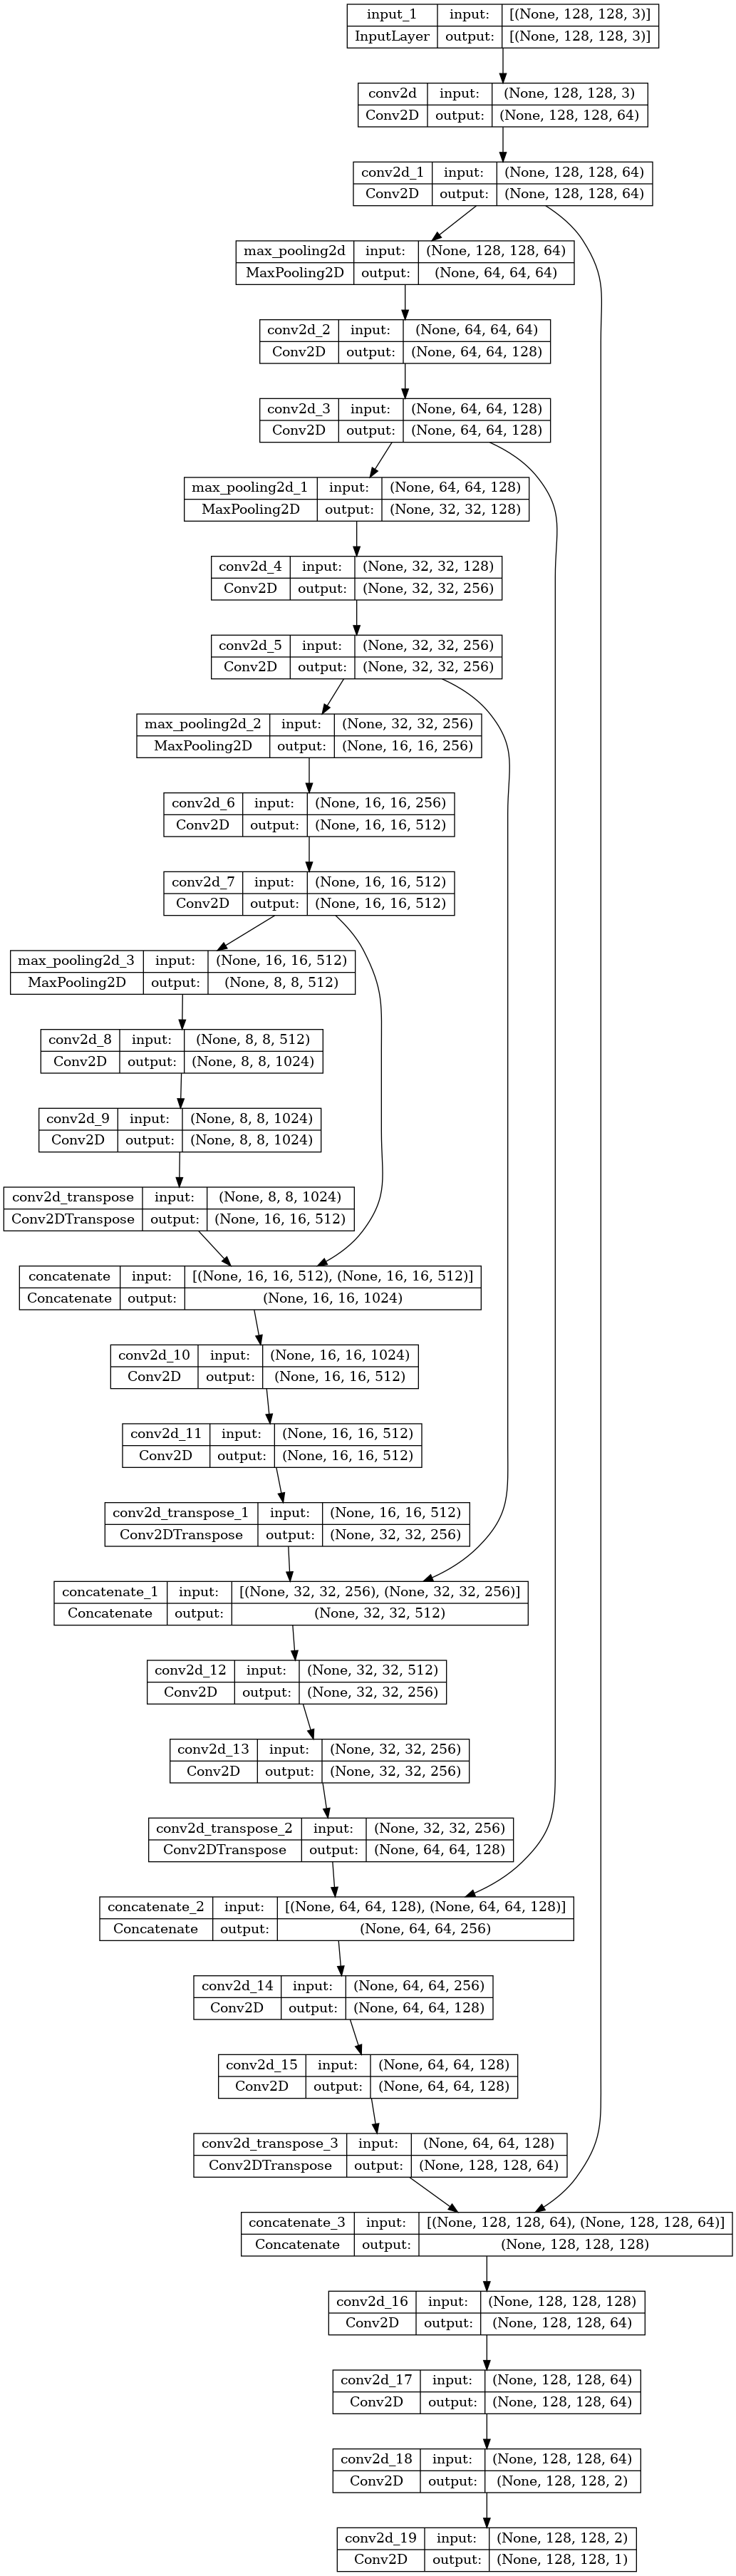

In [11]:
import keras
keras.utils.plot_model(model, to_file = "Model.png", show_shapes=True)

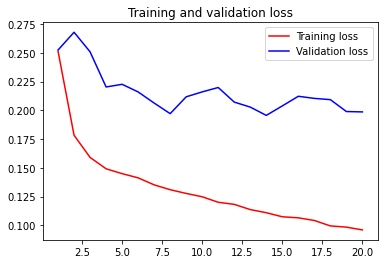

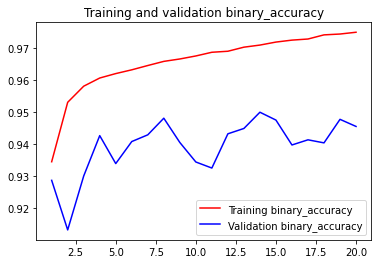

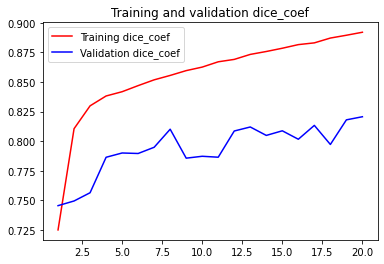

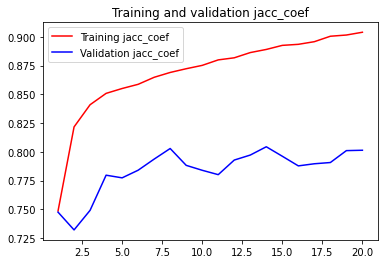

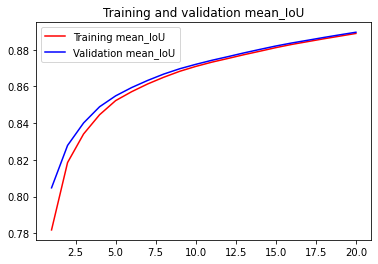

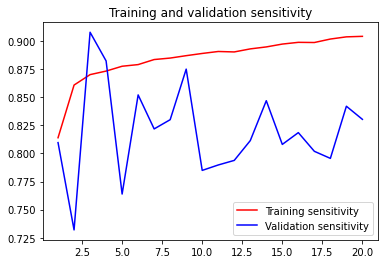

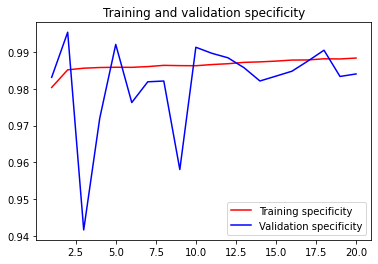

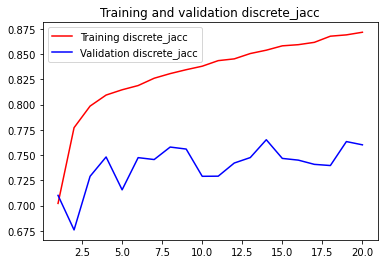

Min/Max Validation val_loss 0.19560521841049194 0.26788803935050964
Min/Max Validation val_binary_accuracy 0.9131924510002136 0.9500345587730408
Min/Max Validation val_dice_coef 0.7455577850341797 0.8206988573074341
Min/Max Validation val_jacc_coef 0.7321117520332336 0.8043946027755737
Min/Max Validation val_mean_IoU 0.8048015236854553 0.8895316123962402
Min/Max Validation val_sensitivity 0.7319592833518982 0.9077277183532715
Min/Max Validation val_specificity 0.9415743947029114 0.9954457879066467
Min/Max Validation val_discrete_jacc 0.6758947968482971 0.7652198672294617


In [3]:
plot_graphs(history, smooth=False)

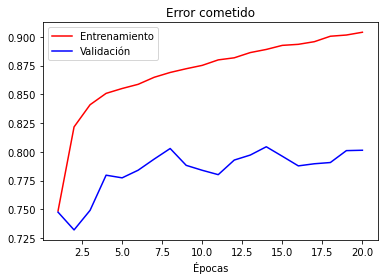

In [4]:
import matplotlib.pyplot as plt
key = "jacc_coef"
training = history[key]
validation = history[f'val_{key}'] 
epochs = range(1, len(training) + 1)

plt.figure()
plt.plot(epochs, training, 'r', label=f'Entrenamiento')
plt.plot(epochs, validation, 'b', label=f'Validación')
plt.xlabel("Épocas")
#plt.ylabel("Y-Axis")
plt.title(f'Error cometido')
plt.legend()

plt.show()

In [3]:
from load import MakeDataset, Clahe_Dataset
isic_dataset = Clahe_Dataset(test_images, test_masks, image_size, mask_size, len(test_images), 1)
ph2_dataset = Clahe_Dataset(ph2_images, ph2_masks, image_size, mask_size, len(ph2_images), 1)

In [6]:
isic_results = model.evaluate(isic_dataset, steps=len(test_images))

2022-11-21 17:06:50.570277: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-21 17:06:51.780595: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-21 17:06:52.076634: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-21 17:06:52.076686: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-21 17:06:52.196250: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

600/600 [==============================] - 22s 28ms/step - loss: 0.2075 - binary_accuracy: 0.9280 - dice_coef: 0.8240 - jacc_coef: 0.7925 - mean_IoU: 0.8163 - sensitivity: 0.8004 - specificity: 0.9784 - discrete_jacc: 0.7435


In [7]:
ph2_results = model.evaluate(ph2_dataset, steps=len(ph2_images))

200/200 [==============================] - 5s 26ms/step - loss: 0.1261 - binary_accuracy: 0.9452 - dice_coef: 0.8945 - jacc_coef: 0.8739 - mean_IoU: 0.8252 - sensitivity: 0.9549 - specificity: 0.9476 - discrete_jacc: 0.8573


In [6]:
import numpy as np
def apply_clahe(img, image_size, clahe):
    image = cv2.imread(img)
    image = cv2.resize(image, image_size)
    blue, green, red = cv2.split(image)

    red = np.asarray(red)
    green = np.asarray(green)
    blue = np.asarray(blue)

    red_clahe = clahe.apply(red)
    green_clahe = clahe.apply(green)
    blue_clahe = clahe.apply(blue)

    clahe_image = cv2.merge((red_clahe, green_clahe, blue_clahe))
    return np.asarray(clahe_image) / 255

In [13]:
from load import read_image, read_mask
from metrics import discrete_jacc
import cv2

cl = cv2.createCLAHE(3, (3, 3))
def evaluations(images, masks, clahe=False):   
    evaluations = []
    for ipath, mpath in zip(images, masks):
        if clahe: img = apply_clahe(ipath, image_size, cl)
        else: img = read_image(ipath, image_size)
        img = np.expand_dims(img, axis=0)
        mask = read_mask(mpath, mask_size)

        pred = model.predict(img)
        jacc = discrete_jacc(mask, pred)
        evaluations.append((ipath, mpath, jacc))
    evaluations.sort(key=lambda x: x[2])
    return evaluations

1/1 [==============================] - 0s 24ms/step
dataset/PH2/images/IMD088.jpg dataset/PH2/masks/IMD088_lesion.jpg
1/1 [==============================] - 0s 22ms/step
tf.Tensor(0.9387994, shape=(), dtype=float32)


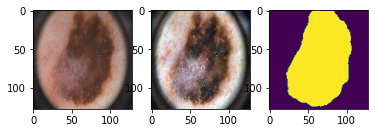

dataset/PH2/images/IMD065.jpg dataset/PH2/masks/IMD065_lesion.jpg
1/1 [==============================] - 0s 28ms/step
tf.Tensor(0.9395905, shape=(), dtype=float32)


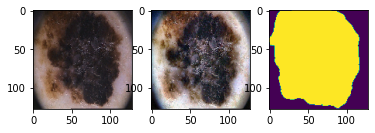

dataset/PH2/images/IMD383.jpg dataset/PH2/masks/IMD383_lesion.jpg
1/1 [==============================] - 0s 23ms/step
tf.Tensor(0.94083524, shape=(), dtype=float32)


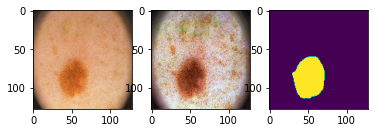

dataset/PH2/images/IMD370.jpg dataset/PH2/masks/IMD370_lesion.jpg
1/1 [==============================] - 0s 25ms/step
tf.Tensor(0.9409882, shape=(), dtype=float32)


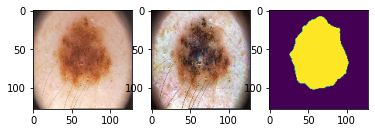

dataset/PH2/images/IMD144.jpg dataset/PH2/masks/IMD144_lesion.jpg
1/1 [==============================] - 0s 25ms/step
tf.Tensor(0.9414101, shape=(), dtype=float32)


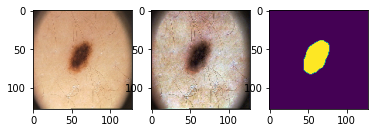

dataset/PH2/images/IMD339.jpg dataset/PH2/masks/IMD339_lesion.jpg
1/1 [==============================] - 0s 24ms/step
tf.Tensor(0.941469, shape=(), dtype=float32)


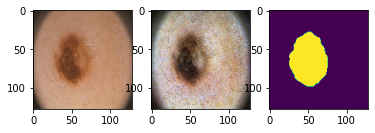

dataset/PH2/images/IMD031.jpg dataset/PH2/masks/IMD031_lesion.jpg
1/1 [==============================] - 0s 23ms/step
tf.Tensor(0.9420765, shape=(), dtype=float32)


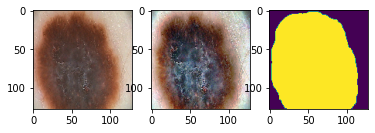

dataset/PH2/images/IMD169.jpg dataset/PH2/masks/IMD169_lesion.jpg
1/1 [==============================] - 0s 25ms/step
tf.Tensor(0.9421875, shape=(), dtype=float32)


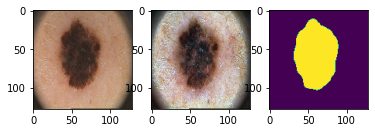

dataset/PH2/images/IMD369.jpg dataset/PH2/masks/IMD369_lesion.jpg
1/1 [==============================] - 0s 23ms/step
tf.Tensor(0.9422638, shape=(), dtype=float32)


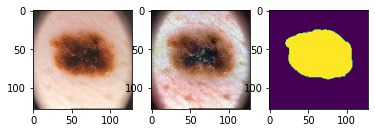

dataset/PH2/images/IMD393.jpg dataset/PH2/masks/IMD393_lesion.jpg
1/1 [==============================] - 0s 24ms/step
tf.Tensor(0.9428349, shape=(), dtype=float32)


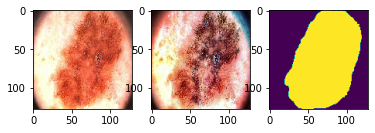

dataset/PH2/images/IMD386.jpg dataset/PH2/masks/IMD386_lesion.jpg
1/1 [==============================] - 0s 22ms/step
tf.Tensor(0.9435798, shape=(), dtype=float32)


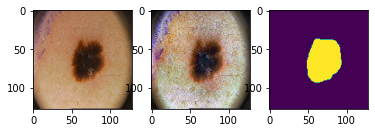

dataset/PH2/images/IMD389.jpg dataset/PH2/masks/IMD389_lesion.jpg
1/1 [==============================] - 0s 24ms/step
tf.Tensor(0.9442894, shape=(), dtype=float32)


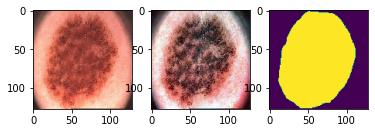

dataset/PH2/images/IMD203.jpg dataset/PH2/masks/IMD203_lesion.jpg
1/1 [==============================] - 0s 23ms/step
tf.Tensor(0.94441354, shape=(), dtype=float32)


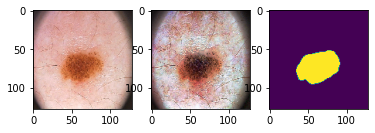

dataset/PH2/images/IMD171.jpg dataset/PH2/masks/IMD171_lesion.jpg
1/1 [==============================] - 0s 23ms/step
tf.Tensor(0.9456336, shape=(), dtype=float32)


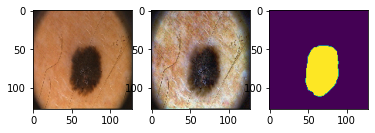

dataset/PH2/images/IMD173.jpg dataset/PH2/masks/IMD173_lesion.jpg
1/1 [==============================] - 0s 23ms/step
tf.Tensor(0.9459519, shape=(), dtype=float32)


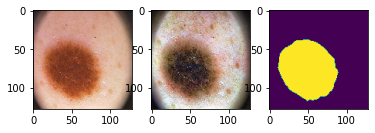

dataset/PH2/images/IMD118.jpg dataset/PH2/masks/IMD118_lesion.jpg
1/1 [==============================] - 0s 23ms/step
tf.Tensor(0.9460127, shape=(), dtype=float32)


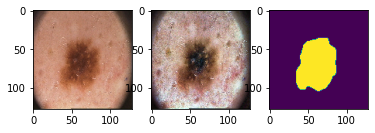

dataset/PH2/images/IMD437.jpg dataset/PH2/masks/IMD437_lesion.jpg
1/1 [==============================] - 0s 22ms/step
tf.Tensor(0.94624543, shape=(), dtype=float32)


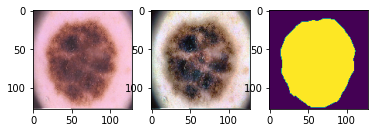

dataset/PH2/images/IMD176.jpg dataset/PH2/masks/IMD176_lesion.jpg
1/1 [==============================] - 0s 25ms/step
tf.Tensor(0.9471342, shape=(), dtype=float32)


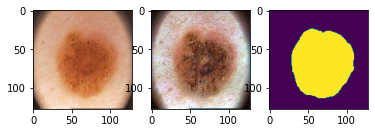

dataset/PH2/images/IMD134.jpg dataset/PH2/masks/IMD134_lesion.jpg
1/1 [==============================] - 0s 27ms/step
tf.Tensor(0.94775105, shape=(), dtype=float32)


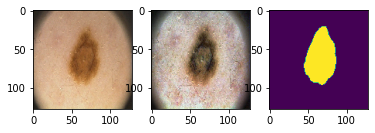

dataset/PH2/images/IMD349.jpg dataset/PH2/masks/IMD349_lesion.jpg
1/1 [==============================] - 0s 24ms/step
tf.Tensor(0.9515706, shape=(), dtype=float32)


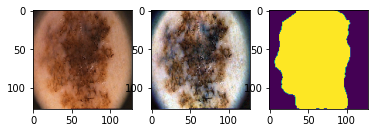

dataset/PH2/images/IMD419.jpg dataset/PH2/masks/IMD419_lesion.jpg
1/1 [==============================] - 0s 30ms/step
tf.Tensor(0.95251256, shape=(), dtype=float32)


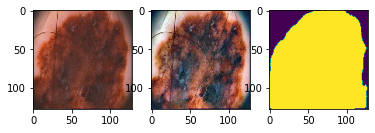

dataset/PH2/images/IMD208.jpg dataset/PH2/masks/IMD208_lesion.jpg
1/1 [==============================] - 0s 25ms/step
tf.Tensor(0.9552638, shape=(), dtype=float32)


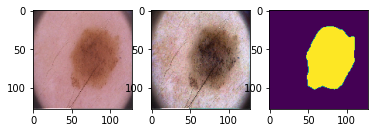

dataset/PH2/images/IMD161.jpg dataset/PH2/masks/IMD161_lesion.jpg
1/1 [==============================] - 0s 20ms/step
tf.Tensor(0.95672405, shape=(), dtype=float32)


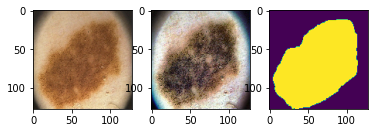

dataset/PH2/images/IMD063.jpg dataset/PH2/masks/IMD063_lesion.jpg
1/1 [==============================] - 0s 21ms/step
tf.Tensor(0.95742345, shape=(), dtype=float32)


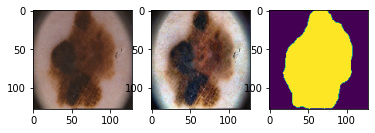

dataset/PH2/images/IMD064.jpg dataset/PH2/masks/IMD064_lesion.jpg
1/1 [==============================] - 0s 20ms/step
tf.Tensor(0.95804834, shape=(), dtype=float32)


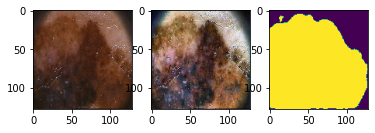

dataset/PH2/images/IMD427.jpg dataset/PH2/masks/IMD427_lesion.jpg
1/1 [==============================] - 0s 22ms/step
tf.Tensor(0.96032035, shape=(), dtype=float32)


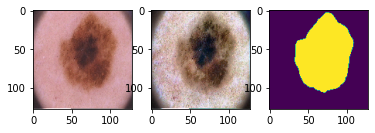

dataset/PH2/images/IMD382.jpg dataset/PH2/masks/IMD382_lesion.jpg
1/1 [==============================] - 0s 40ms/step
tf.Tensor(0.960997, shape=(), dtype=float32)


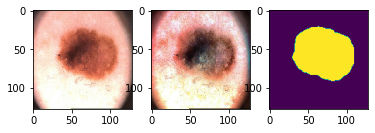

dataset/PH2/images/IMD159.jpg dataset/PH2/masks/IMD159_lesion.jpg
1/1 [==============================] - 0s 22ms/step
tf.Tensor(0.9651555, shape=(), dtype=float32)


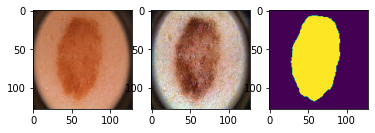

dataset/PH2/images/IMD160.jpg dataset/PH2/masks/IMD160_lesion.jpg
1/1 [==============================] - 0s 21ms/step
tf.Tensor(0.9673086, shape=(), dtype=float32)


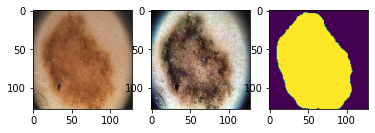

dataset/PH2/images/IMD017.jpg dataset/PH2/masks/IMD017_lesion.jpg
1/1 [==============================] - 0s 21ms/step
tf.Tensor(0.97122747, shape=(), dtype=float32)


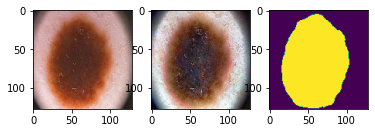

In [14]:
ph2_evaluations = evaluations(ph2_images, ph2_masks, True)
import matplotlib.pyplot as plt
for ipath, mpath, value in ph2_evaluations[-30:]:
    print(ipath, mpath)
    img = read_image(ipath, image_size)
    mask = read_mask(mpath, mask_size)
    clahe = apply_clahe(ipath, image_size, cl)
    clahe = np.expand_dims(clahe, axis=0)
    pred = model.predict(clahe)
    
    f, ax = plt.subplots(1,3)
    ax[0].imshow(img)
    ax[1].imshow(clahe.squeeze(axis=0))
    #ax[2].imshow(mask)
    ax[2].imshow(pred[0].squeeze(axis=2).round())
    print(value)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


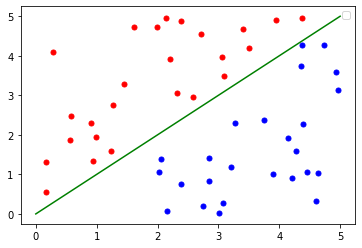

In [33]:
import matplotlib.pyplot as plt
import random


red, blue = [], []
for i in range(50):
    x = random.random() * 5
    y = random.random() * 5
    if x < y: red.append((x, y))
    else: blue.append((x, y))

xp = np.linspace(0, 5, 5)

plt.figure()
plt.plot(xp, xp, 'g')

for x, y in red: plt.plot([x], [y], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
for x, y in blue: plt.plot([x], [y], marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="blue")

#plt.title(f'Error cometido')
plt.legend()

[0.44383034, 0.46245134, 0.47632775, 0.47757867, 0.5078534, 0.55191433, 0.57202137, 0.5946309, 0.6067137, 0.62956667, 0.6308453, 0.63265306, 0.65500945, 0.6657912, 0.6854568, 0.6866044, 0.6929252, 0.7060316, 0.7209691, 0.723556, 0.7264697, 0.7355389, 0.74047065, 0.74267685, 0.74622566, 0.75527424, 0.75821215, 0.763823, 0.77874184, 0.7789364, 0.7798344, 0.78880405, 0.7891253, 0.7907648, 0.7946935, 0.7964377, 0.8018293, 0.80832225, 0.80956024, 0.8109147, 0.81132585, 0.8146718, 0.81557983, 0.8180657, 0.8194683, 0.821227, 0.82331645, 0.82350516, 0.8236473, 0.8266143, 0.8298573, 0.8300262, 0.831795, 0.8332014, 0.8354365, 0.83597946, 0.8400981, 0.8410306, 0.8419127, 0.8425889, 0.84273845, 0.84974426, 0.8506614, 0.8516058, 0.85176367, 0.85211915, 0.8521699, 0.8538441, 0.85577756, 0.85642713, 0.85689163, 0.85875046, 0.8686627, 0.8688406, 0.86915886, 0.8708433, 0.87170833, 0.87285066, 0.8732084, 0.8735955, 0.8741234, 0.87484115, 0.8751472, 0.8752884, 0.8761782, 0.8769367, 0.8774492, 0.87941176,

<AxesSubplot:>

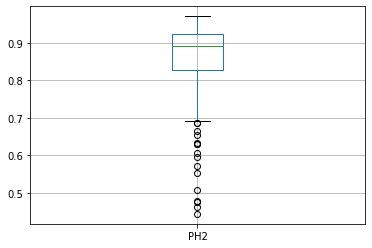

In [18]:
import pandas as pd

ph2_evaluations = evaluations(ph2_images, ph2_masks, True)
isic_evaluations = evaluations(test_images, test_masks, True)

ph2_evaluations = [i[2].numpy() for i in ph2_evaluations]
isic_evaluations = [i[2].numpy() for i in isic_evaluations]

print(e)
df = pd.DataFrame({'PH2': ph2_evaluations,
                    'ISIC': isic_evaluations})
df.boxplot(column='PH2')
